# **7. Validacion Avanzada, Tuning e Interpretabilidad a los modelos estudiados**

## 7. XGBoost

In [23]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC



from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, classification_report, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
import joblib
import os 



Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [24]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [25]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [29]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


In [30]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()


xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_estimators=500,
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1
    ))
])

In [31]:
param_space = {
    'classifier__max_depth': (3, 10),
    'classifier__learning_rate': (0.01, 0.3, 'log-uniform'),
    'classifier__subsample': (0.5, 1.0, 'uniform'),
    'classifier__colsample_bytree': (0.5, 1.0, 'uniform'),
    'classifier__min_child_weight': (1, 10),
    'classifier__gamma': (0.0, 5.0, 'uniform'),
    'classifier__reg_lambda': (0.0, 10.0, 'uniform'),
    'classifier__reg_alpha': (0.0, 10.0, 'uniform')
}

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search = BayesSearchCV(
    estimator=xgb_pipe,
    search_spaces=param_space,
    n_iter=55,                # puedes aumentar a 50+ si tienes más tiempo
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [33]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                         (...
              search_spaces={'classifier__colsample_bytree': (0.5, 1.0,
                                                              'uniform'),
                             'classifier__gamma': (0.0, 5.0, 'uniform'),
                             'classifier__learning_rate': (0.01, 0.3,
                                                           'log-uniform'),
                             'classifier__max_depth': (3, 10),
                             'classifier__min_child_weight': (1, 10),
                             'classifier__reg_alpha': (0.0, 10.0, 'uniform'),
                             'classifier__reg_lambda': (0.0, 10.0, 'uniform'),
                             'classifier__subsample': (0.5, 1.0, 'uniform')},
              verbose=2)

In [34]:
best_xgb = bayes_search.best_estimator_

print("Mejores hiperparámetros:", bayes_search.best_params_)
print("Mejor AUC (CV):", bayes_search.best_score_)

y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:,1]

print("\nMétricas en test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: OrderedDict([('classifier__colsample_bytree', 0.6178270308869578), ('classifier__gamma', 1.6918026180213865), ('classifier__learning_rate', 0.11081724798111653), ('classifier__max_depth', 6), ('classifier__min_child_weight', 10), ('classifier__reg_alpha', 3.7832939106502805), ('classifier__reg_lambda', 9.782922316459892), ('classifier__subsample', 0.8227065806018466)])
Mejor AUC (CV): 0.6970748796984528

Métricas en test:
Accuracy: 0.6454750908912253
Precision: 0.6123041809316319
Recall: 0.6291440144973883
F1: 0.6206098843322818
AUC: 0.6996236500805103


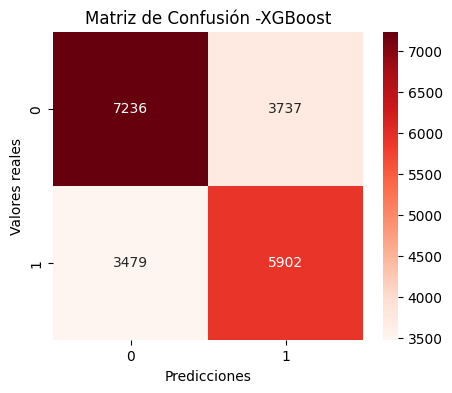

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión -XGBoost")
plt.show()



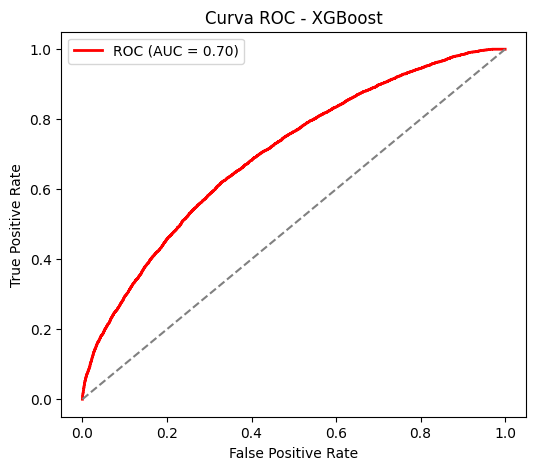

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.show()

In [37]:
joblib.dump(best_xgb, "best_xgb_pipeline.pkl")
print("Modelo XGBoost guardado en best_xgb_pipeline.pkl")

Modelo XGBoost guardado en best_xgb_pipeline.pkl


In [ ]:
os.system('start "" "C:\\Users\\taran\\OneDrive\\Documents\\Cyberpunk 2077 SFX Johnny silverhand glitch 04 (Sound Effect).mp3"')  # en Windows


In [ ]:
xgb.plot_importance(model, importance_type='gain')
plt.show()